In [3]:
import numpy as np
from collections import Counter
import trueskillthroughtime as ttt
import matplotlib.pyplot as plt
import pickle
import bz2
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from math import log


In [4]:
def LogLoss(outcome, prob):
    if outcome == True:
        result = 1
    else:
        result = 0
    return -1 * ((result * log(prob+.000001)) + ((1 - result) * log(1-prob+.000001)))

In [5]:
#Plot Text Size Control
SMALL_SIZE = 11
MEDIUM_SIZE = 13
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the plot title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams['figure.figsize'] = (12, 5)


In [6]:

with open('/Users/cameron/Documents/SMU_DS/Capstone/SMU_Capstone_Project/Pickle_Files/vball_game_data.pbz2', 'rb') as file:
    uncompressed = bz2.BZ2File(file)
    vball = pickle.load(uncompressed)

#Create TrueSkill Through Time Implementation
vball.shape[0]/4


51574.0

In [7]:
len(np.unique(vball['tournamentId']))

645

In [8]:


#Initialize every player into a dictionary
def initialize_players(vball=vball,mu_val=0.0,sigma_val=6.0,beta_val=1.0,gamma_val=0.03):
    unique_players=np.unique(vball['player_id'])
    player_ratings=dict()
    for i in unique_players:
        player_ratings[i]=ttt.Player(ttt.Gaussian(mu=mu_val, sigma=sigma_val),beta=beta_val,gamma=gamma_val)
    return player_ratings


def run_simulation(vball=vball,train_size=20000,mu_val=0.0,sigma_val=6.0,beta_val=1.0,gamma_val=0.03,log_loss_check=False):
    
    player_ratings=initialize_players(vball,mu_val,sigma_val,beta_val,gamma_val)
        
    #Run through every match and update mu and sigma after
    #Looping through every 4th row because the algorithm takes the both teams at once
    loop=0
    prediction=[]
    log_loss=0
    log_loss_counter=0
    final_outputs=[]
    for i in vball[::4]:
        outputs=[]
        
        ##First step is to store winning and losing team
        if i['win']==True:
            winning_team = [player_ratings[i['player_id']], player_ratings[i['teammate_id']]]
            losing_team = [player_ratings[i['opponent1_id']], player_ratings[i['opponent2_id']]]
        if i['win']==False:
            losing_team = [player_ratings[i['player_id']], player_ratings[i['teammate_id']]]
            winning_team = [player_ratings[i['opponent1_id']], player_ratings[i['opponent2_id']]]    

        #Next step is to generate a new mu and sigma for every player based on the result
        g = ttt.Game([winning_team, losing_team]) #Winning team must go first
        pos=g.posteriors()
        
        win_pct_chance=round(g.evidence,5)

        loop+=1
        if loop > train_size:
            if win_pct_chance > .5:
                prediction.append(1)
                outputs.append(1)
                log_loss+=LogLoss(True,g.evidence)
                log_loss_counter+=1
            elif win_pct_chance == .5:
                prediction.append(0)
                outputs.append(0)
            else:
                prediction.append(-1)
                outputs.append(-1)
                log_loss+=LogLoss(False,g.evidence)
                log_loss_counter+=1

            #append winning team (mu,sigma)
            outputs.append((list(pos[0][0])[0]+list(pos[0][1])[0])/2)

            #append losing team (mu,sigma)
            outputs.append((list(pos[1][0])[0]+list(pos[1][1])[0])/2)
            
            #append skill gap winning team
            outputs.append(abs(list(pos[0][0])[0]-list(pos[0][1])[0]))
            
            #append skill gap losing team
            outputs.append(abs(list(pos[1][0])[0]-list(pos[1][1])[0]))

            #append percentage points won
            if i['ignored_score']==True or i['incomplete_score']==True:
                outputs.append(-1)
            elif i['win']==True:
                outputs.append(i['pct_points_won'])
            elif i['win']==False:
                outputs.append(1-i['pct_points_won'])

            #append percent chance of winning
            outputs.append(round(g.evidence,4))
            
            #Append all of the outputs as one element
            final_outputs.append(list(outputs))

        #Next we store the new mu and sigma into the player rating dictionary
        if i['win']==True:
            player_ratings[i['player_id']]=ttt.Player(pos[0][0])
            player_ratings[i['teammate_id']]=ttt.Player(pos[0][1])
            player_ratings[i['opponent1_id']]=ttt.Player(pos[1][0])
            player_ratings[i['opponent2_id']]=ttt.Player(pos[1][1])
        if i['win']==False:
            player_ratings[i['player_id']]=ttt.Player(pos[1][0])
            player_ratings[i['teammate_id']]=ttt.Player(pos[1][1])
            player_ratings[i['opponent1_id']]=ttt.Player(pos[0][0])
            player_ratings[i['opponent2_id']]=ttt.Player(pos[0][1])

    hits=len([x for x in prediction if x==1])
    misses=len([x for x in prediction if x==-1])
    ties=len([x for x in prediction if x==0])
    if (hits+misses)!=0:
        acc=hits/(hits+misses)
    else:
        acc=0
    
    #Outputs contain: Binary Outcome, WT avg mu, LT avg mu, WT skill gap, LT skill gap, % points won, and % chance of winning
    if log_loss_check:
        log_loss_final=log_loss/log_loss_counter
        return acc,final_outputs,log_loss_final
        
    else:
        return acc,final_outputs

def plot_acc_curve(final_acc,parameter="Input Parameter"):
    max_acc=max(final_acc,key=lambda x:x[1])
    print("Max Acc: ",max_acc[1],'\n',parameter,': ',max_acc[0],sep='')
    plt.plot([x[0] for x in final_acc], [x[1] for x in final_acc])
    plt.xticks([x[0] for x in final_acc])  # add this or the plot api will add extra ticks
    #plt.xticks(rotation=90)
    plt.xlabel(parameter)
    plt.ylabel("Accuracy")
    plt.title(label=str("Accuracy by " + parameter))
    plt.show()
    


Max Acc: 0.7449
Train Size: 30000


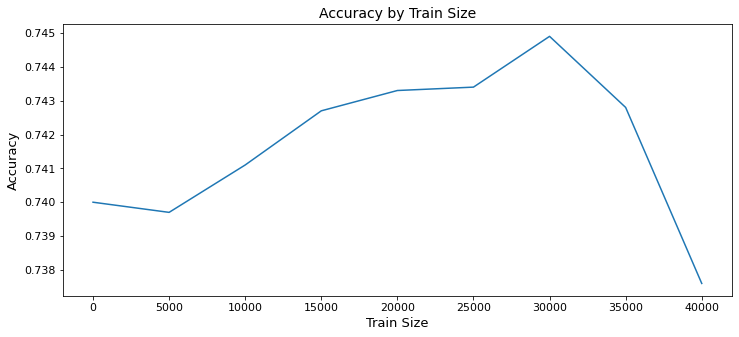

Max Acc: 0.7516
Sigma Size: 2.5


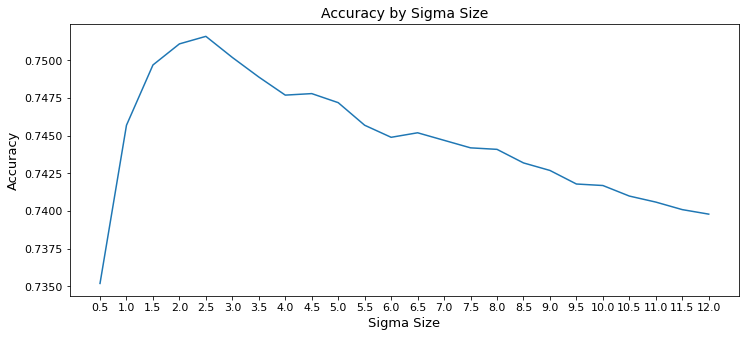

Max Acc: 0.7521
Beta Size: 0.5


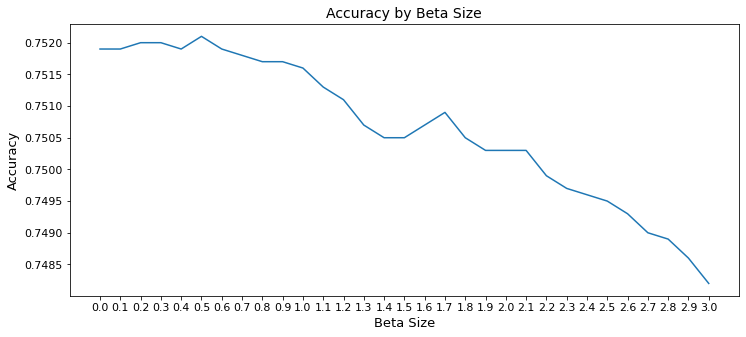

Max Acc: 0.7521
Mu Size: 0


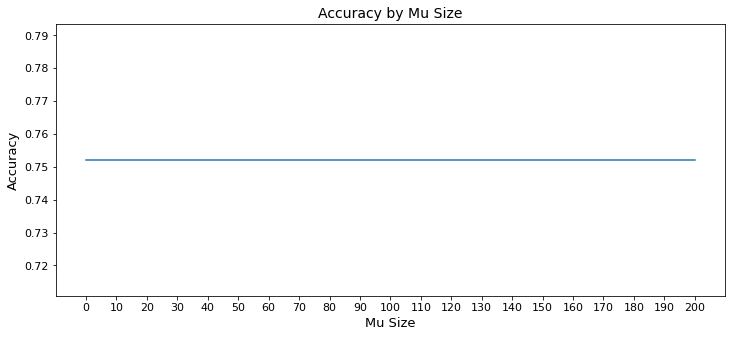

Max Acc: 0.7521
Training Size: 30000


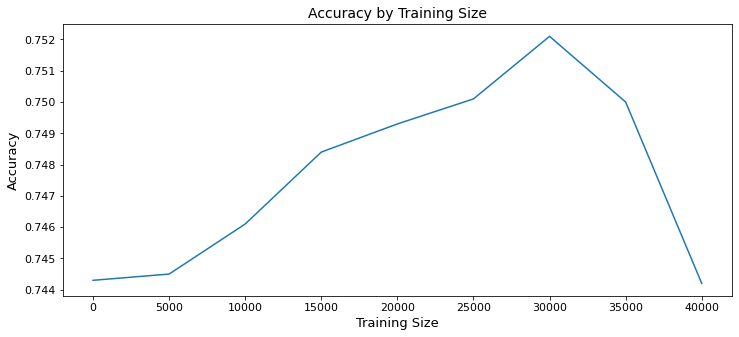

In [53]:

#Test multiple training sizes
training_size_test=[x for x in range(0,40001,5000)]
final_acc=[]
for i in training_size_test:
    acc,outputs=run_simulation(vball=vball,train_size=i,mu_val=0.0,sigma_val=6.0,beta_val=1.0,gamma_val=0.03)
    final_acc.append([i,round(acc,4)])

plot_acc_curve(final_acc=final_acc,parameter="Train Size")

#Test multiple sigma sizes (use train_size of 30000)
sigma_size_test=[x/2 for x in range(1,25)]
final_acc=[]
for i in sigma_size_test:
    acc,outputs=run_simulation(vball=vball,train_size=30000,mu_val=0.0,sigma_val=i,beta_val=1.0,gamma_val=0.03)
    final_acc.append([i,round(acc,4)])

plot_acc_curve(final_acc=final_acc,parameter="Sigma Size")

#Test multiple beta sizes (use train_size of 30000 and sigma size of 2.5)
beta_size_test=[x/10 for x in range(0,31)]
final_acc=[]
for i in beta_size_test:
    acc,outputs=run_simulation(vball=vball,train_size=30000,mu_val=0.0,sigma_val=2.5,beta_val=i,gamma_val=0.03)
    final_acc.append([i,round(acc,4)])

plot_acc_curve(final_acc=final_acc,parameter="Beta Size")

#Test multiple mu sizes (use train_size of 30000)
mu_size_test=[x for x in range(0,201,10)]
final_acc=[]
for i in mu_size_test:
    acc,outputs=run_simulation(vball=vball,train_size=30000,mu_val=i,sigma_val=2.5,beta_val=0.5,gamma_val=0.03)
    final_acc.append([i,round(acc,4)])

plot_acc_curve(final_acc=final_acc,parameter="Mu Size")

#Test multiple training sizes
training_size_test=[x for x in range(0,40001,5000)]
final_acc=[]
for i in training_size_test:
    acc,outputs=run_simulation(vball=vball,train_size=i,mu_val=0,sigma_val=2.5,beta_val=0.5,gamma_val=0.03)
    final_acc.append([i,round(acc,4)])

plot_acc_curve(final_acc=final_acc,parameter="Training Size")


In [9]:
acc,outputs,log_loss_final=run_simulation(vball=vball,train_size=30000,mu_val=0,sigma_val=2.5,beta_val=0.5,gamma_val=0.03,log_loss_check=True)
print(acc)
print(log_loss_final)
print(Counter([x[0] for x in outputs]))

0.7521319463967763
0.27371134693799365
Counter({1: 16052, -1: 5290, 0: 232})


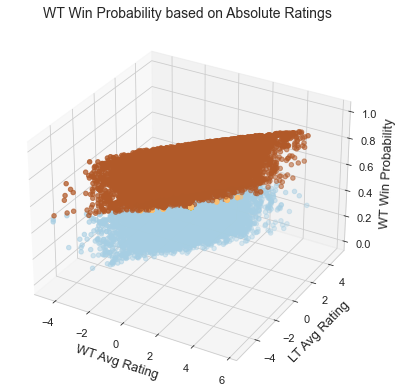

In [10]:

#Analyze outputs from optimized model
acc,outputs=run_simulation(vball=vball,train_size=30000,mu_val=0,sigma_val=2.5,beta_val=0.5,gamma_val=0.03)

#Outputs contain: Binary Outcome, WT avg mu, LT avg mu, WT skill gap, LT skill gap, % points won, and % chance of winning
#Understand skill range and gap range
out_array_labels=['game_outcome', 'WT avg mu', 'LT avg mu', 'WT skill gap', 'LT skill gap',' % points won', '% win estimate']
out_array=np.array(outputs)
out_array.shape
out_array[0]

#Visualize Data

#3D Plot WT Rating, LT Rating, and WT Win Probability
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure()

ax = Axes3D(fig)

x = out_array[:,1]
y = out_array[:,2]
z = out_array[:,6]

ax.scatter(x, y, z, c=out_array[:,0],cmap='Paired', marker='o')
ax.set_xlabel('WT Avg Rating')
ax.set_ylabel('LT Avg Rating')
ax.set_zlabel('WT Win Probability')
ax.set_title('WT Win Probability based on Absolute Ratings')

plt.show()


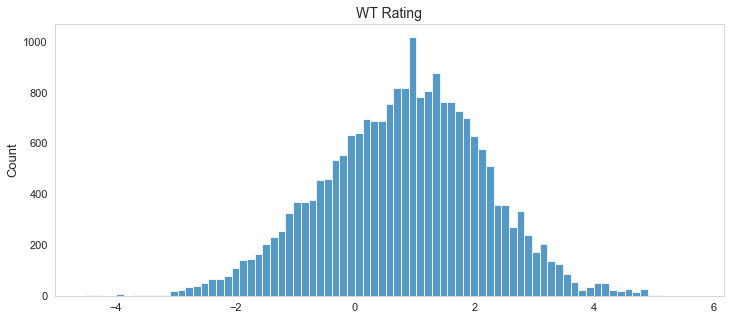

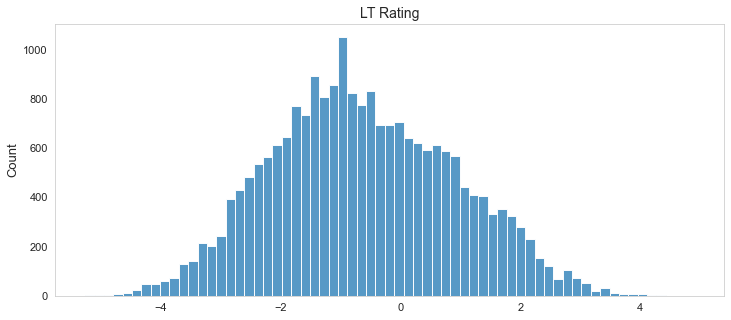

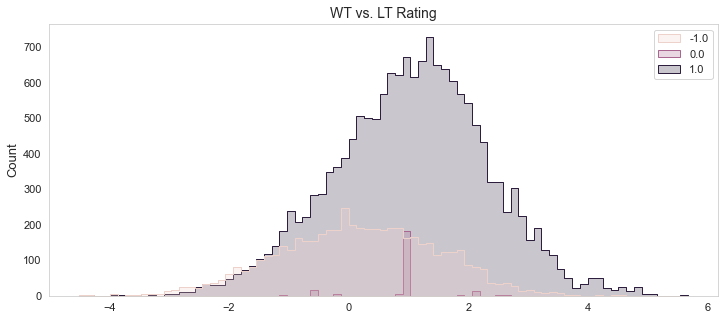

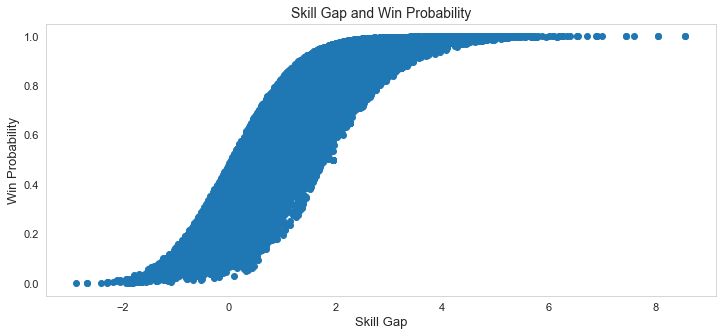

In [11]:

#WT Rating Histogram
sns.histplot(out_array[:,1])
plt.title('WT Rating')
plt.show()

#LT Rating Histogram
sns.histplot(out_array[:,2])
plt.title('LT Rating')
plt.show()

#Distribution of ratings of winning team when correct vs incorrect
sns.histplot(out_array, x=out_array[:,1], hue=out_array[:,0], element="step",color='blue')
plt.title('WT vs. LT Rating')
plt.show()

#Rating Gap and WT Probability
plt.scatter(out_array[:,1]-out_array[:,2],out_array[:,6])
plt.title('Skill Gap and Win Probability')
plt.xlabel('Skill Gap')
plt.ylabel('Win Probability')
plt.show()


#Outputs contain: Binary Outcome, WT avg mu, LT avg mu, WT skill gap, LT skill gap, % points won, and % chance of winning


In [12]:
#Plot Text Size Control
SMALL_SIZE = 11
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the plot title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams['figure.figsize'] = (12, 8)


In [13]:

#Outputs contain: Binary Outcome, WT avg mu, LT avg mu, WT skill gap, LT skill gap, % points won, and % chance of winning
out_array=np.array(outputs)
out_array.shape

#Remove ties
out_array_no_ties=out_array[out_array[:,0]!=0,:]
out_array_no_ties.shape

#Create bins
lb=-4
ub=4
increment=.25
bins_lt=[[round(x*.01,2),round(x*.01+increment,2)] for x in range(int(lb*100),int(ub*100),int(increment*100))]
bins_wt=bins_lt.copy()
bins_wt.reverse()


game_count_array=np.zeros((len(bins_wt),len(bins_lt)))
exp_win_prob_array=np.zeros((len(bins_wt),len(bins_lt)))
actual_win_prob=np.zeros((len(bins_wt),len(bins_lt)))


#Capture game count in each bin (after training)
for i in out_array_no_ties:
    for ix,x in enumerate(bins_wt):
        for iy,y in enumerate(bins_lt):
            if x[0]<=i[1]<x[1] and y[0]<=i[2]<y[1]:
                game_count_array[ix,iy]+=1

#Capture expected win probability
for i in out_array_no_ties:
    for ix,x in enumerate(bins_wt):
        for iy,y in enumerate(bins_lt):
            if x[0]<=i[1]<x[1] and y[0]<=i[2]<y[1]:
                exp_win_prob_array[ix,iy]+=i[6]/game_count_array[ix,iy]

#Capture actual win probability
for i in out_array_no_ties:
    for ix,x in enumerate(bins_wt):
        for iy,y in enumerate(bins_lt):
            if x[0]<=i[1]<x[1] and y[0]<=i[2]<y[1] and i[0]==1:
                actual_win_prob[ix,iy]+=i[0]/game_count_array[ix,iy]

#Capture residual of actual - expected win probability
residual_win_prob=actual_win_prob-exp_win_prob_array


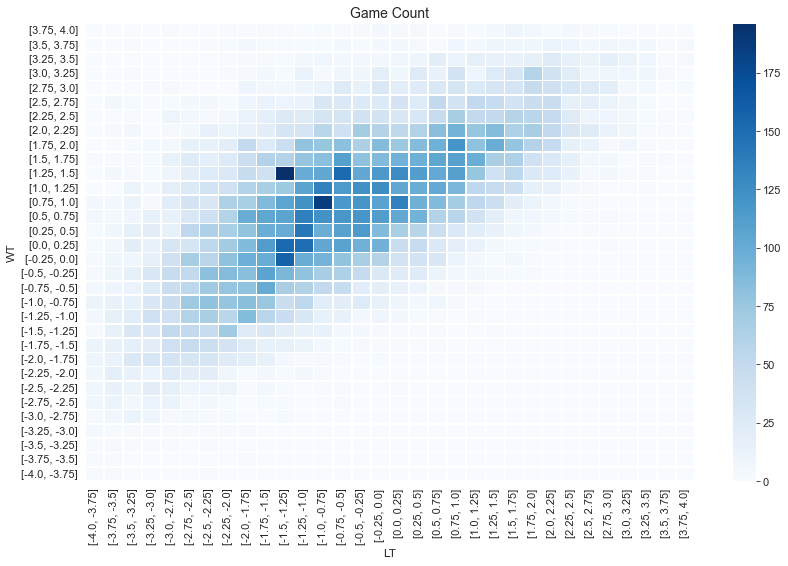

In [14]:

#Plot heatmap of game count
plt.clf()  # For clearing plot
sns.heatmap(
    game_count_array,
    cmap="Blues",
    xticklabels=bins_lt,
    yticklabels=bins_wt,
    linewidth=0.5,
)
plt.xlabel("LT")
plt.ylabel("WT")
plt.title("Game Count")
plt.tight_layout()
plt.show()


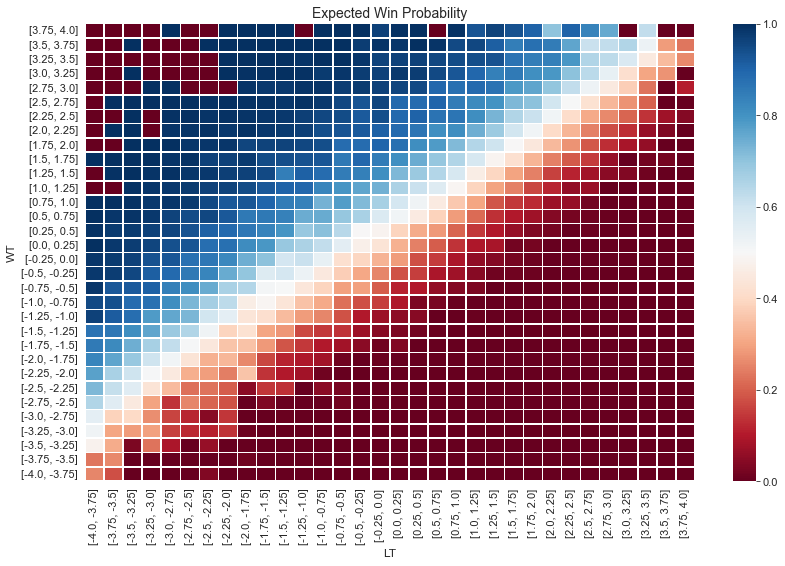

In [15]:

#Plot heatmap of expected win probability
plt.clf()  # For clearing plot
sns.heatmap(
    exp_win_prob_array,
    cmap="RdBu",
    xticklabels=bins_lt,
    yticklabels=bins_wt,
    linewidth=0.5,
)
plt.xlabel("LT")
plt.ylabel("WT")
plt.title("Expected Win Probability")
plt.tight_layout()
plt.show()


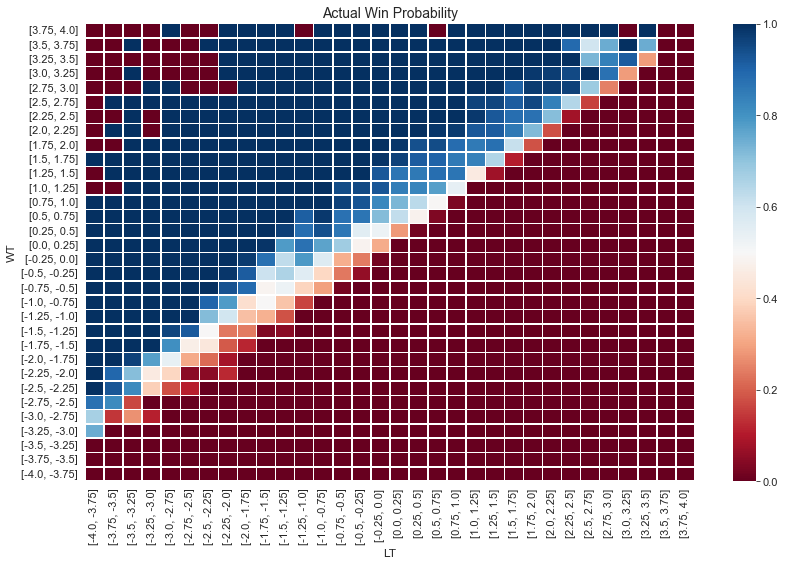

In [16]:

#Plot heatmap of actual win probability
plt.clf()  # For clearing plot
sns.heatmap(
    actual_win_prob,
    cmap="RdBu",
    xticklabels=bins_lt,
    yticklabels=bins_wt,
    linewidth=0.5,
)
plt.xlabel("LT")
plt.ylabel("WT")
plt.title("Actual Win Probability")
plt.tight_layout()
plt.show()


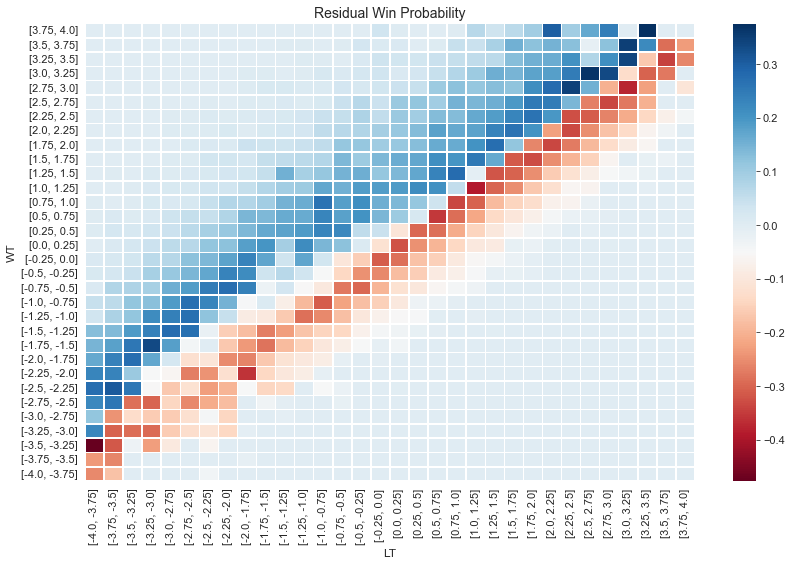

In [17]:

#Plot heatmap of residual win probability
plt.clf()  # For clearing plot
sns.heatmap(
    residual_win_prob,
    cmap="RdBu",
    xticklabels=bins_lt,
    yticklabels=bins_wt,
    linewidth=0.5,
)
plt.xlabel("LT")
plt.ylabel("WT")
plt.title("Residual Win Probability")
plt.tight_layout()
plt.show()

In [18]:
#Average probability miss per game (weighted average of non-absolute value of residuals)
#need to include for extreme ratings
np.sum(np.multiply(residual_win_prob,game_count_array/np.sum(game_count_array)))

0.07155260396795092

In [19]:
#Average probability miss per game (weighted average of absolute value of residuals)
#need to include for extreme ratings
np.sum(np.multiply(np.absolute(residual_win_prob),game_count_array/np.sum(game_count_array)))

0.14641858069439123

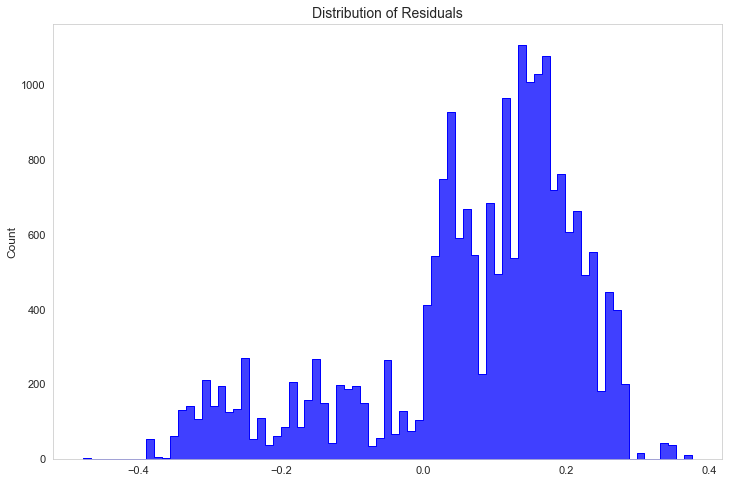

In [20]:
game_list=[y for x in game_count_array for y in x]
residual_win_prob_list=[y for x in residual_win_prob for y in x]
residual_holder_list=[]

for i in range(len(game_list)):
    if game_list[i]>0:
        residual_holder_list=residual_holder_list+[residual_win_prob_list[i]]*int(game_list[i])

#Distribution of ratings of winning team when correct vs incorrect
sns.histplot(residual_holder_list, element="step",color='blue')
plt.title('Distribution of Residuals')
plt.show()

In [25]:
plt.rcdefaults()

In [26]:
revised_bins_lt = []
for idx, item in enumerate(bins_lt):
    if idx%2 == 0:
        revised_bins_lt.append(item)
    else:
        revised_bins_lt.append("")
revised_bins_wt = []
for idx, item in enumerate(bins_wt):
    if idx%2 == 0:
        revised_bins_wt.append(item)
    else:
        revised_bins_wt.append("")

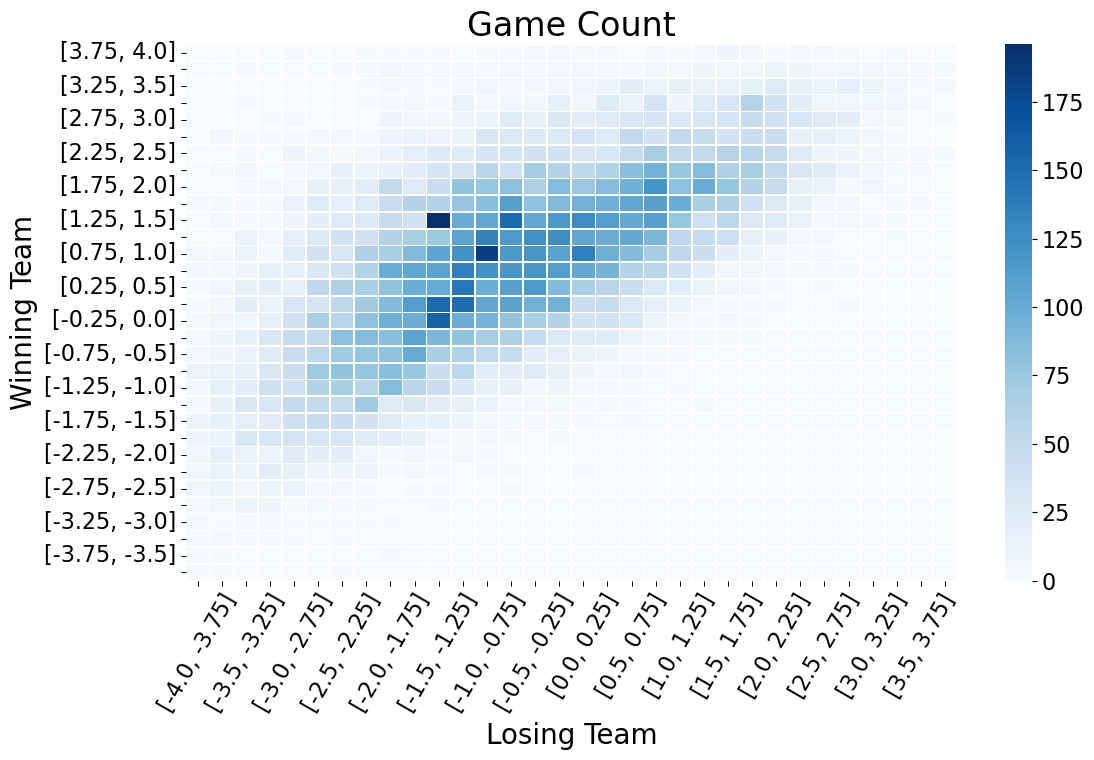

In [31]:
#Plot heatmap of game count
plt.clf()  # For clearing plot
sns.heatmap(
    game_count_array,
    cmap="Blues",
    xticklabels=revised_bins_lt,
    yticklabels=revised_bins_wt,
    linewidth=0.5,
)

plt.xlabel("Losing Team")
plt.ylabel("Winning Team")
plt.rc('font', size=20)  
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16) 
plt.tick_params(axis='x', labelrotation=60)
plt.title("Game Count")
plt.tight_layout()
plt.rcParams['figure.figsize'] = (12, 8)
plt.show()


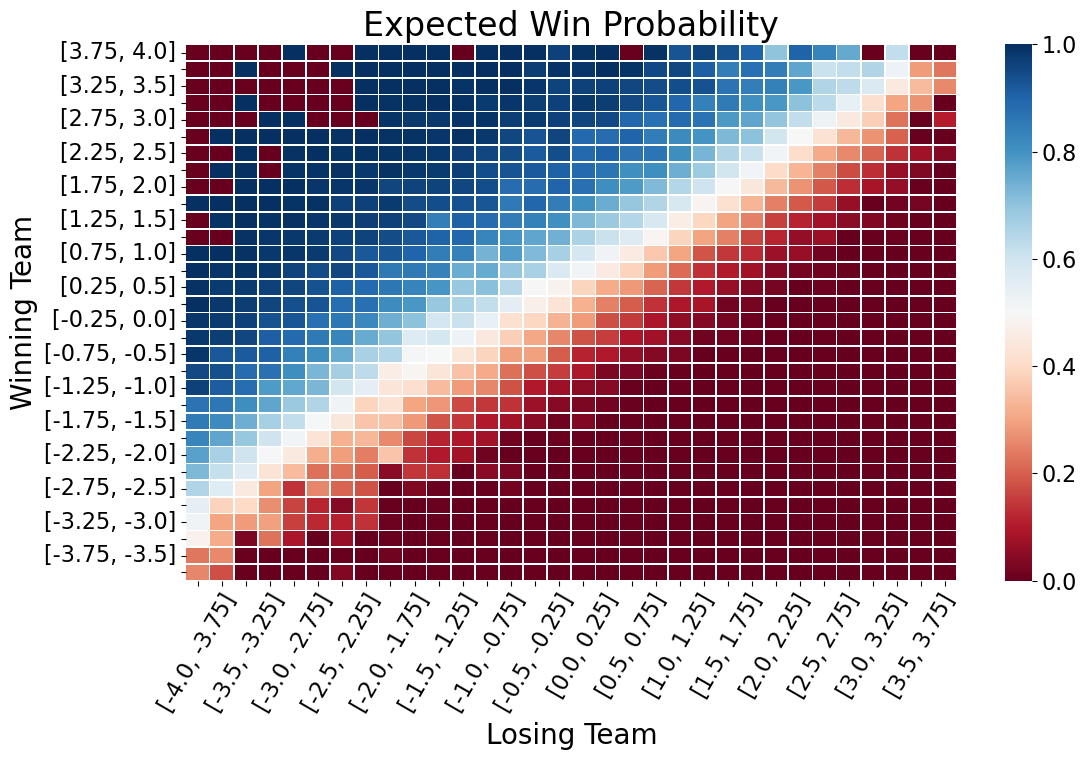

In [28]:
#Plot heatmap of expected win probability
plt.clf()  # For clearing plot
sns.heatmap(
    exp_win_prob_array,
    cmap="RdBu",
    xticklabels=revised_bins_lt,
    yticklabels=revised_bins_wt,
    linewidth=0.5,
)
plt.xlabel("Losing Team")
plt.ylabel("Winning Team")
plt.rc('font', size=20)   
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16) 
plt.tick_params(axis='x', labelrotation=60)
plt.title("Expected Win Probability")
plt.tight_layout()
plt.rcParams['figure.figsize'] = (12, 8)
plt.show()


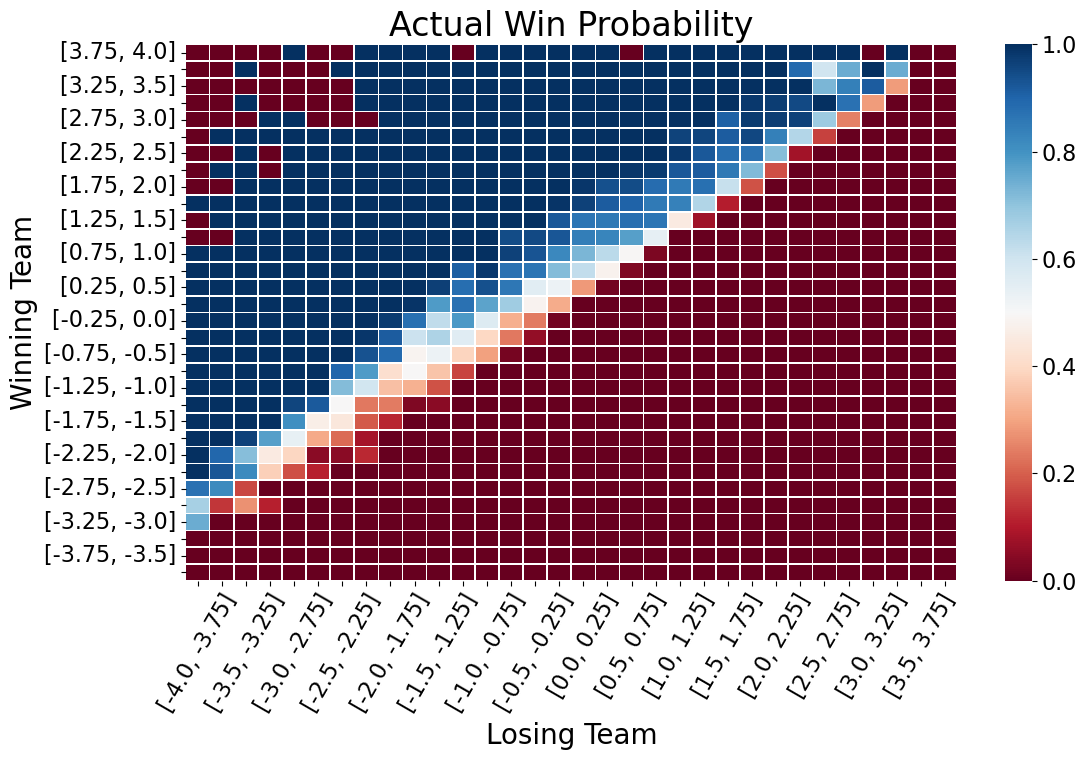

In [29]:
#Plot heatmap of actual win probability
plt.clf()  # For clearing plot
sns.heatmap(
    actual_win_prob,
    cmap="RdBu",
    xticklabels=revised_bins_lt,
    yticklabels=revised_bins_wt,
    linewidth=0.5,
)
plt.xlabel("Losing Team")
plt.ylabel("Winning Team")
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16) 
plt.tick_params(axis='x', labelrotation=60)
plt.title("Actual Win Probability")
plt.tight_layout()
plt.rcParams['figure.figsize'] = (12, 8)
plt.show()


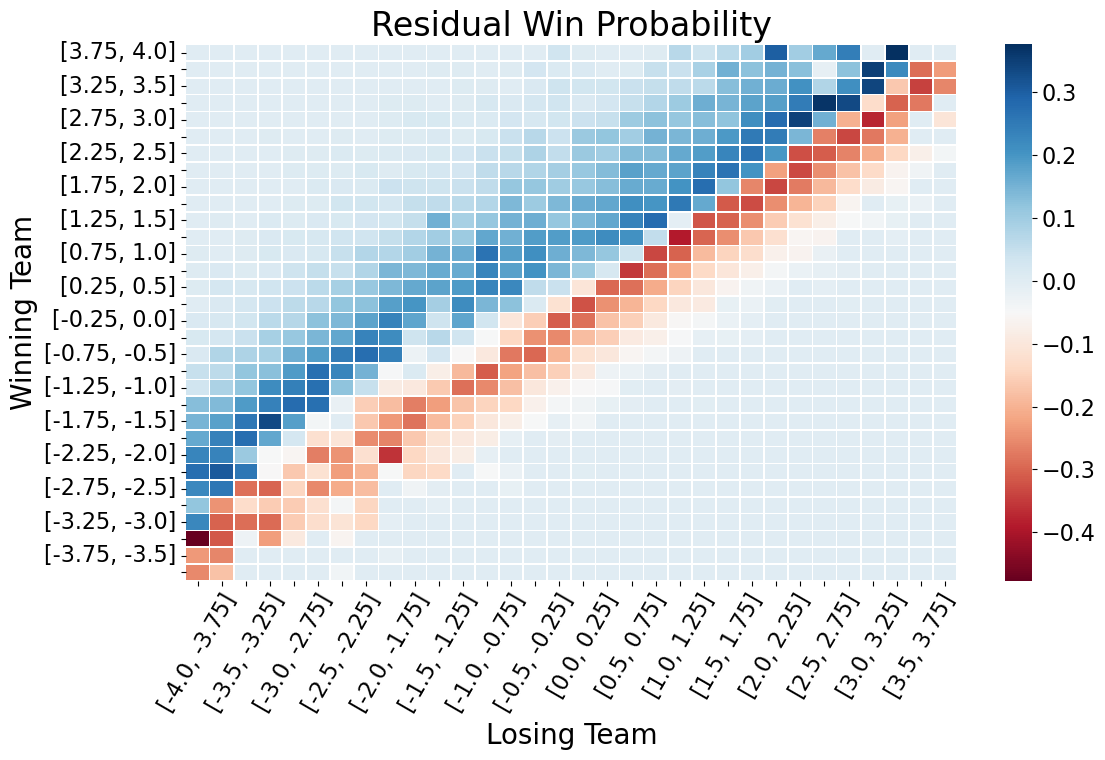

In [30]:
#Plot heatmap of residual win probability
plt.clf()  # For clearing plot
sns.heatmap(
    residual_win_prob,
    cmap="RdBu",
    xticklabels=revised_bins_lt,
    yticklabels=revised_bins_wt,
    linewidth=0.5,
)
plt.xlabel("Losing Team")
plt.ylabel("Winning Team")
plt.rc('font', size=20)   
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16) 
plt.tick_params(axis='x', labelrotation=60)
plt.title("Residual Win Probability")
plt.tight_layout()
plt.rcParams['figure.figsize'] = (12, 8)
plt.show()